In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
from data_handling.Data_Reader import DataReader
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.Ml_methods import Ml_methods
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import wandb
from scipy import stats
from scipy.stats import linregress
import copy
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel, cosine_distances, euclidean_distances
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import pearsonr
from skbio.stats.distance import mantel

In [3]:
params_to_work_with = constants.ALL_PARAMS
ctx_outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB', 'H023_IN', 'H061_SE']
pd_outliers = ['PD028_YO', 'PD037_ES', 'PD044_TS', 'PD056_YK', 'PD004_KC']

In [4]:
def load_data(data_path, rois, outliers=[], data_cols=['subjects', 'Age', 'Gender']):
    subjects_raw_data = DataProcessor(
        data_path, rois, rois, data_cols).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(
        subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(
        analyzed_data, rois, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]

    return chosen_data


def normalize_params(data, params):
    data_copy = copy.deepcopy(data)

    for param in params:
        data_copy[param] = stats.zscore(data_copy[param], nan_policy='omit')

    return data

def show_corr_mean(res1, res2, clusters_rois, title1, title2):
    res1_copy = res1.copy()
    res2_copy = res2.copy()

    np.fill_diagonal(res1_copy.values, 0)
    np.fill_diagonal(res2_copy.values, 0)
    corr_mean1 = res1_copy.apply(np.mean, axis=1)
    corr_mean2 = res2_copy.apply(np.mean, axis=1)

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(clusters_rois, corr_mean1.to_numpy(
    ), color='blue', s=20, alpha=0.7, label=title1)
    ax.scatter(clusters_rois, corr_mean2.to_numpy(
    ), color='red', s=20, alpha=0.7, label=title2)

    ax.set_xticks(clusters_rois)
    ax.set_xticklabels(clusters_rois, rotation='vertical', fontsize=8)

    # Connecting the points with vertical lines
    for x, y1, y2 in zip(clusters_rois, corr_mean1.to_numpy(), corr_mean2.to_numpy()):
        plt.plot([x, x], [y1, y2], color='gray', linestyle='--')

    # ax.set_facecolor('white')
    ax.grid(True)
    ax.legend()

    return corr_mean1, corr_mean2

In [5]:
all_ctx_data_z_score= load_data(
    constants.PATH_TO_CORTEX_all_params_z_score,
    constants.ROI_CORTEX,
    outliers=ctx_outliers)

young_ctx_data_z_score, old_ctx_data_z_score = StatisticsWrapper.seperate_data_to_two_groups(
        all_ctx_data_z_score, 'Age', constants.AGE_THRESHOLD)
print(
    f'num young: {young_ctx_data_z_score.subjects.nunique()}, num old: {old_ctx_data_z_score.subjects.nunique()}')

pd_col_names = ['subjects', 'Age', 'Gender', 'Clinc_group']
all_pd_data_z_score= load_data(
    constants.PATH_TO_PD_CORTEX_all_params_z_score,
    constants.ROI_CORTEX,
    outliers=ctx_outliers,
    data_cols=pd_col_names)

ctl_data_z_score = all_pd_data_z_score[all_pd_data_z_score.Clinc_group == 'CTL']
ctl_data_z_score = ctl_data_z_score[ctl_data_z_score.Age >= constants.AGE_THRESHOLD]
pd_data_z_score = all_pd_data_z_score[all_pd_data_z_score.Clinc_group == 'PD']

print(
    f'num pd: {pd_data_z_score.subjects.nunique()}, num ctl: {ctl_data_z_score.subjects.nunique()}')

num young: 16, num old: 14
num pd: 32, num ctl: 16


In [15]:
print(f'mean age of old subjects: {old_ctx_data_z_score.Age.mean()}. mean age of control subjects: {ctl_data_z_score.Age.mean()}')

mean age of old subjects: 67.42857142857143. mean age of control subjects: 70.9375


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


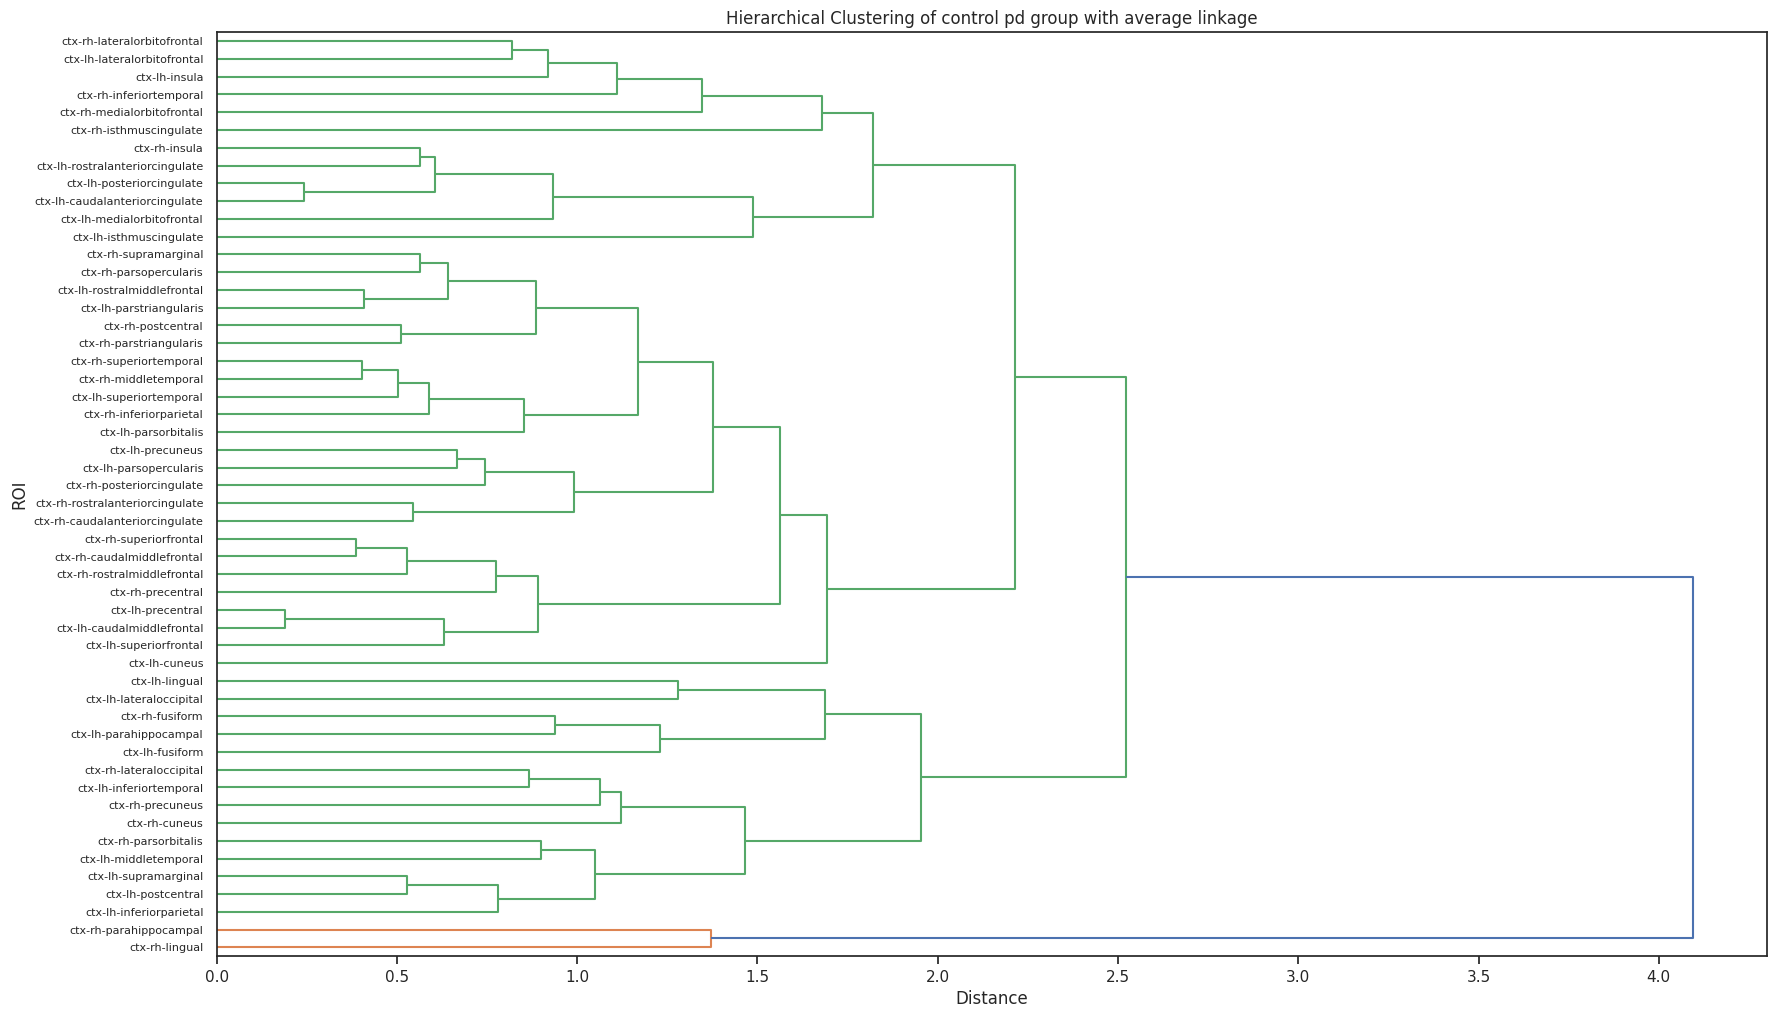

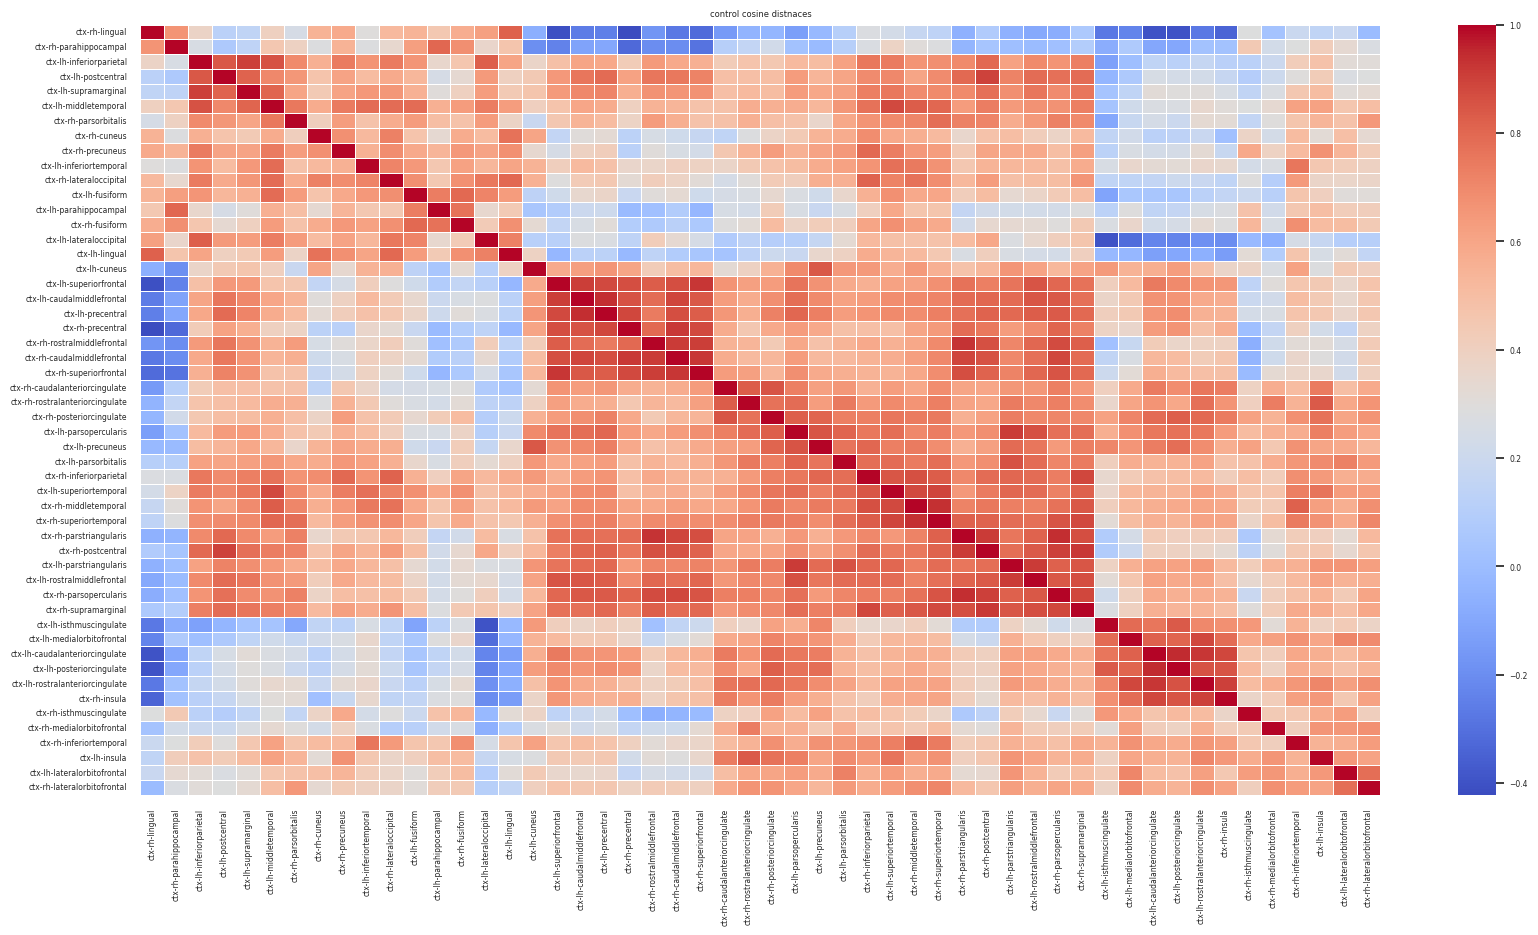

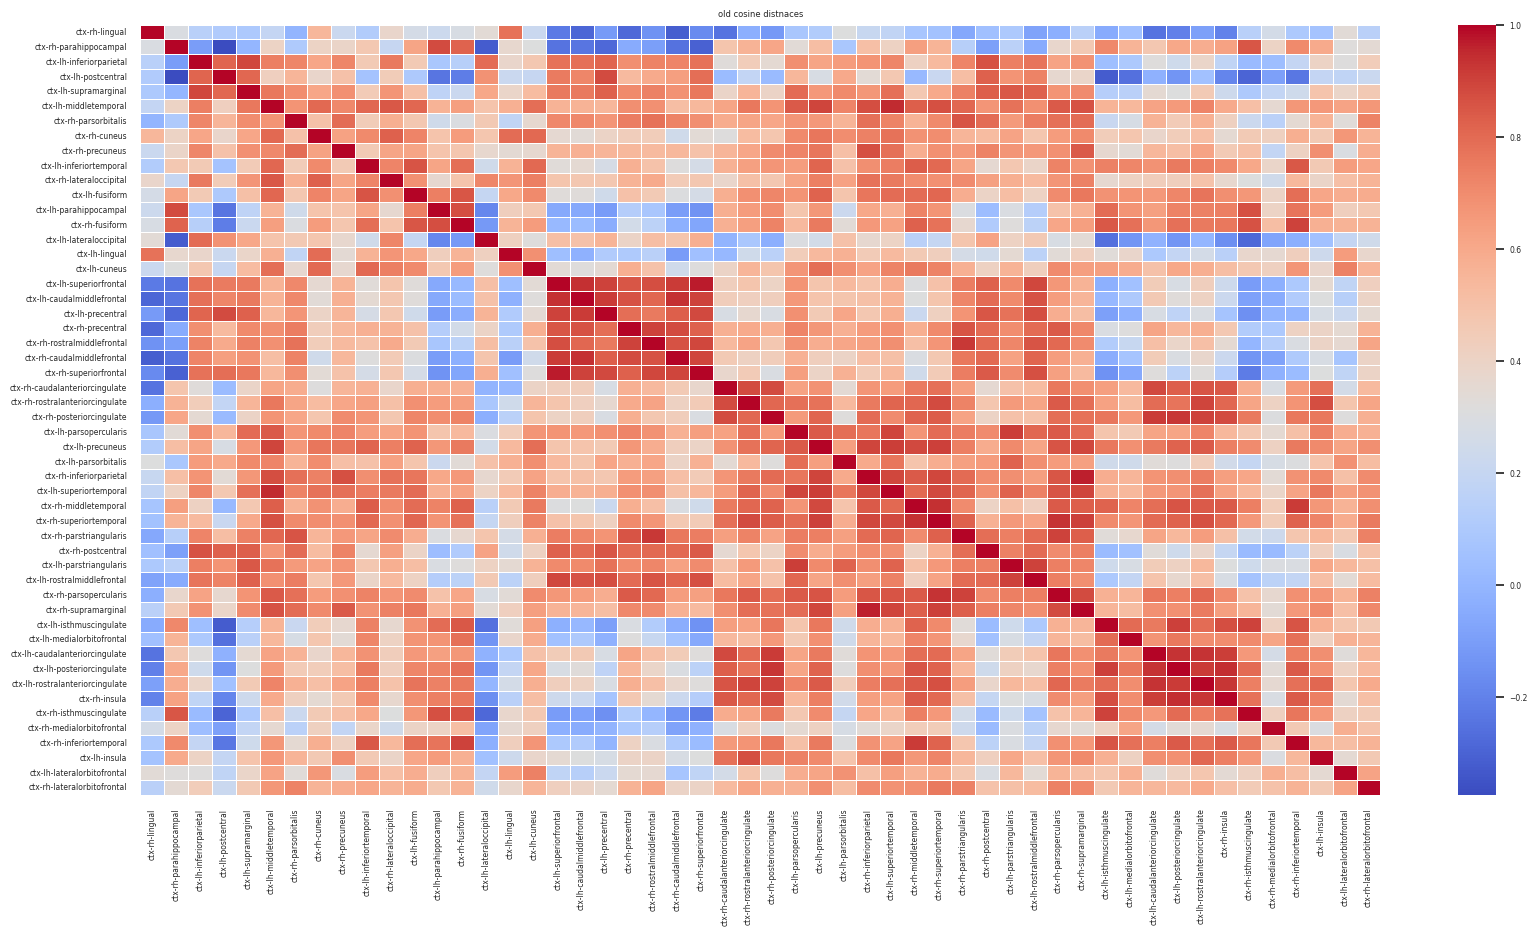

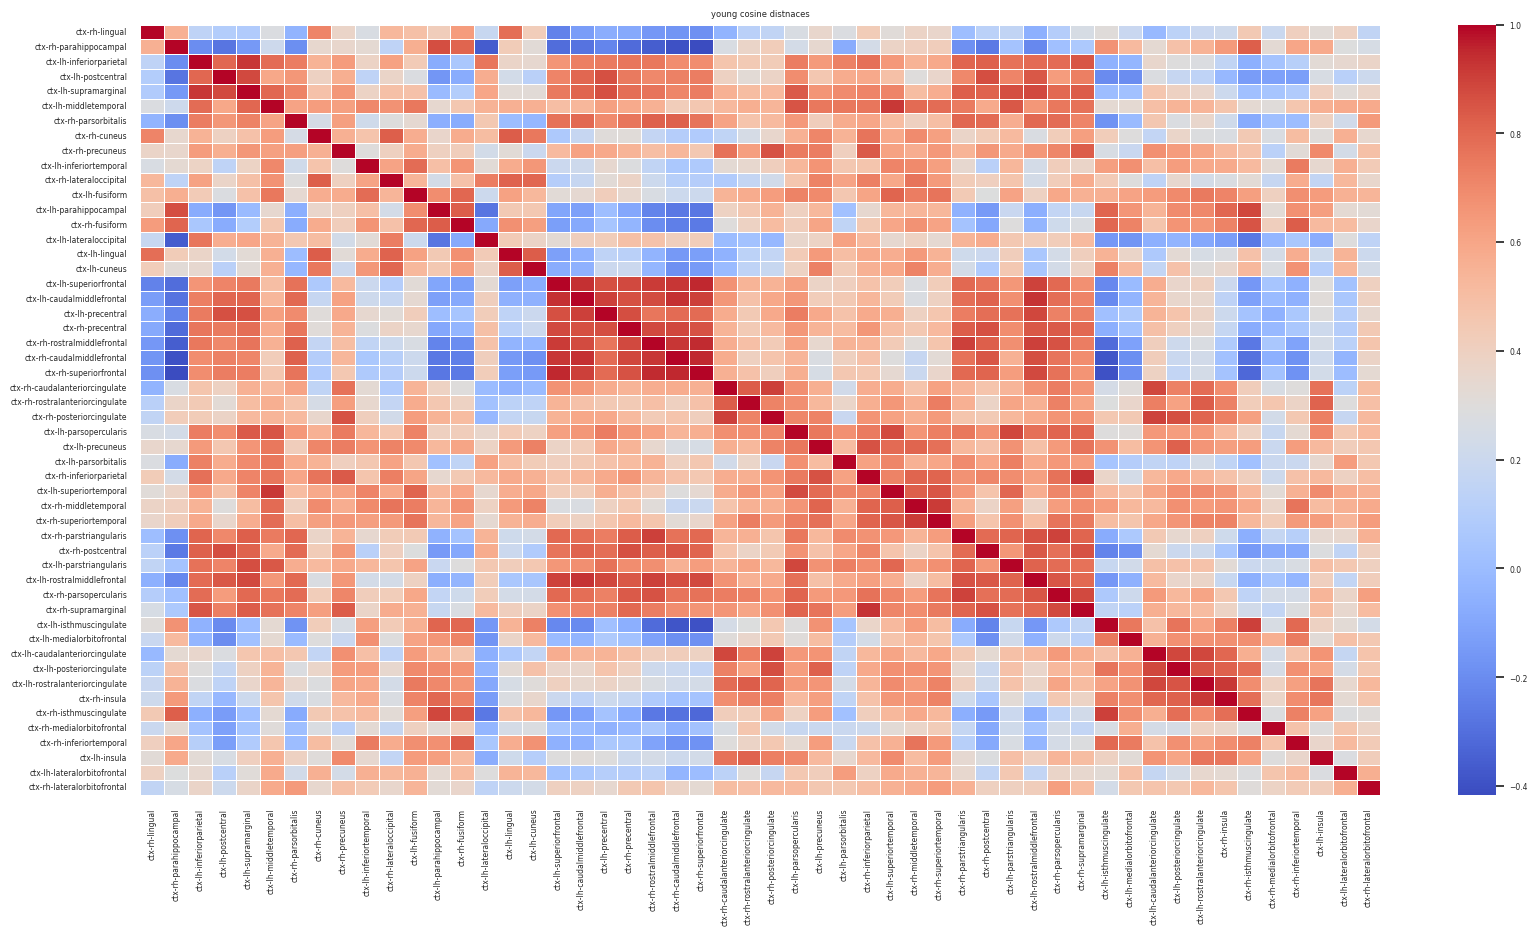

(ctx-rh-lingual                     0.212111
 ctx-rh-parahippocampal             0.192442
 ctx-lh-inferiorparietal            0.486131
 ctx-lh-postcentral                 0.383349
 ctx-lh-supramarginal               0.509265
 ctx-lh-middletemporal              0.575694
 ctx-rh-parsorbitalis               0.422789
 ctx-rh-cuneus                      0.426083
 ctx-rh-precuneus                   0.519732
 ctx-lh-inferiortemporal            0.431786
 ctx-rh-lateraloccipital            0.411004
 ctx-lh-fusiform                    0.530749
 ctx-lh-parahippocampal             0.304102
 ctx-rh-fusiform                    0.362970
 ctx-lh-lateraloccipital            0.259708
 ctx-lh-lingual                     0.342785
 ctx-lh-cuneus                      0.343165
 ctx-lh-superiorfrontal             0.397580
 ctx-lh-caudalmiddlefrontal         0.415150
 ctx-lh-precentral                  0.457720
 ctx-rh-precentral                  0.447875
 ctx-rh-rostralmiddlefrontal        0.392450
 ctx-rh-ca

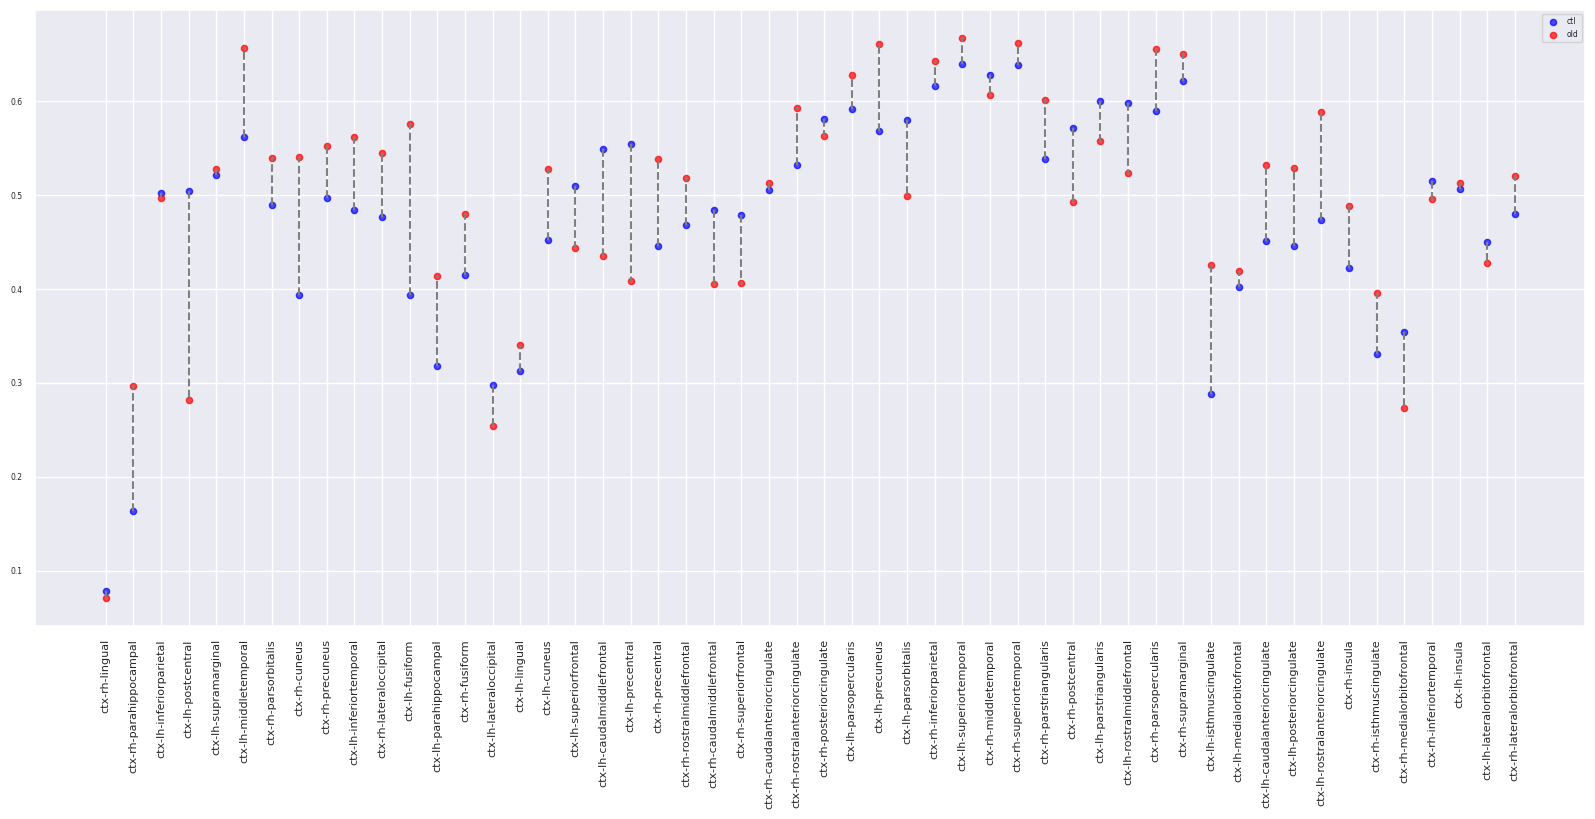

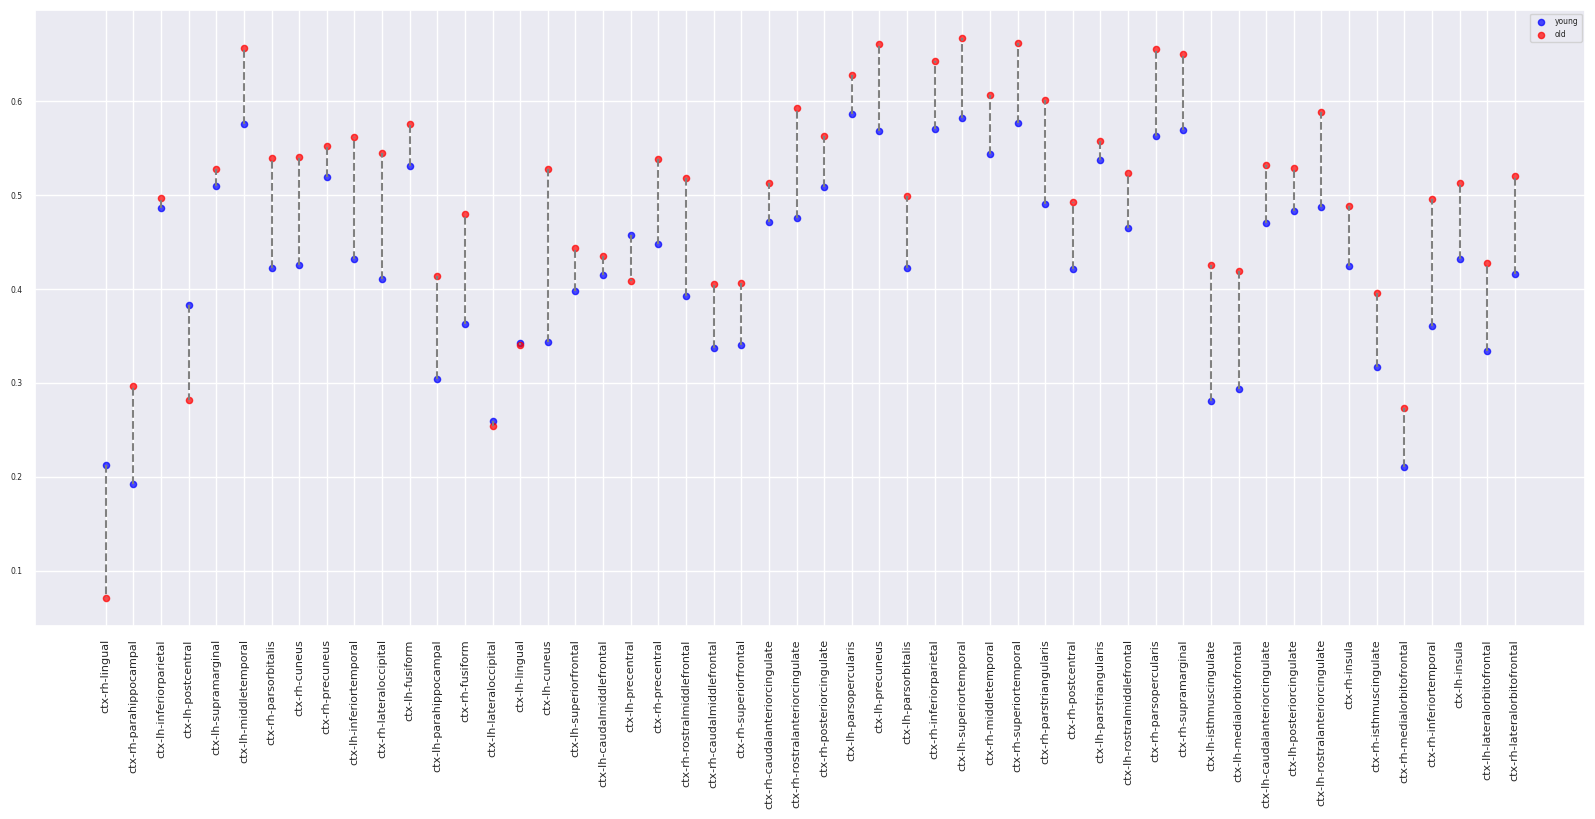

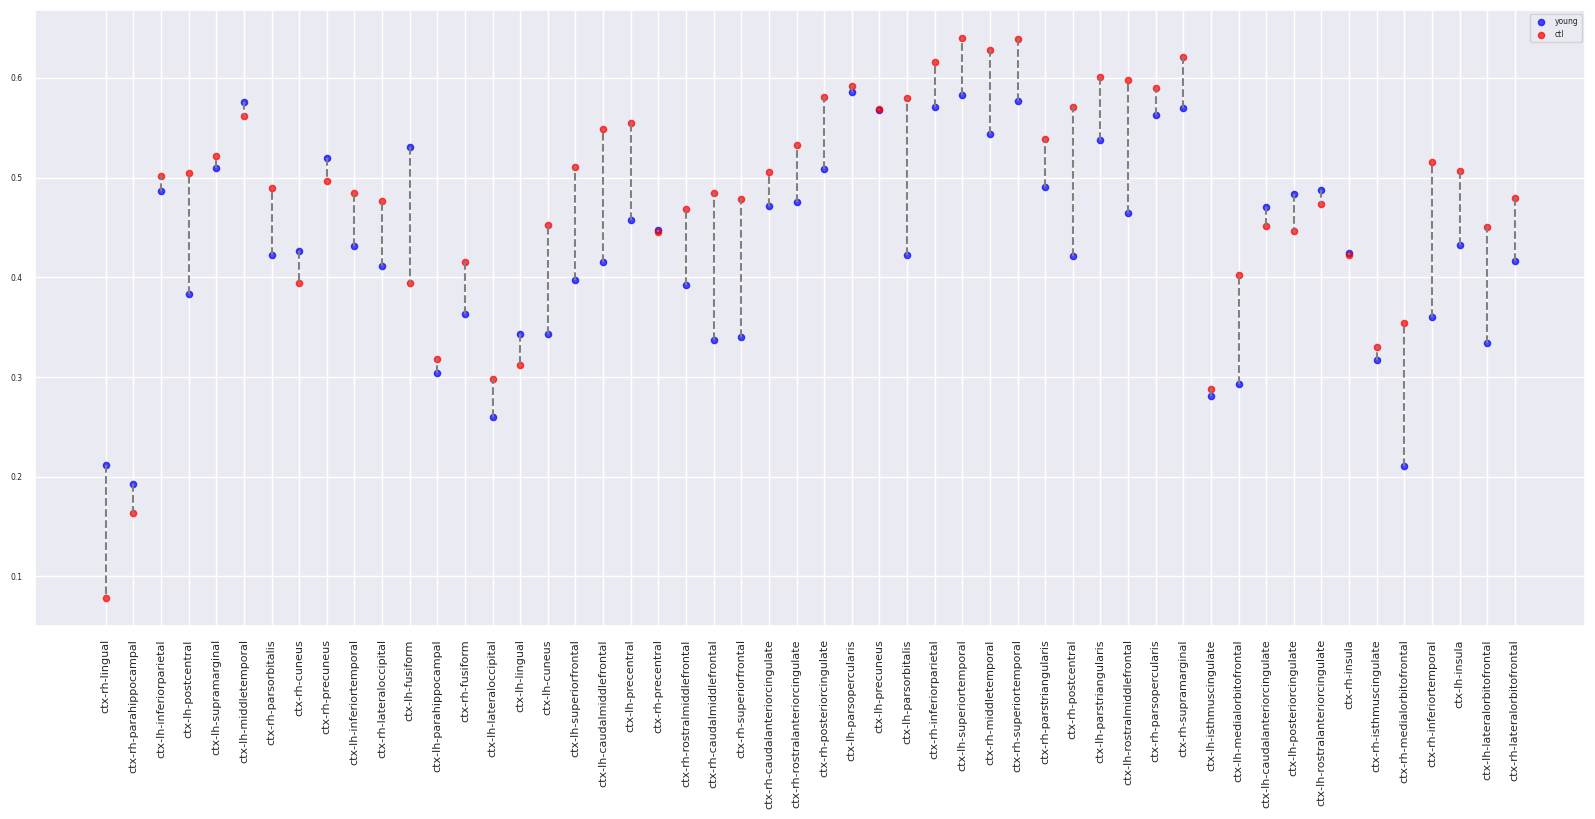

In [7]:
ctl_clustring_data =  StatisticsWrapper.hierarchical_clustering(ctl_data_z_score, params_to_work_with, 'average',
                                                            title="control pd")['dendrogram_data']['ivl']
ctl_distances = StatisticsWrapper.roi_distances(
    ctl_data_z_score, params_to_work_with, ctl_clustring_data, method=cosine_similarity, title=f'control cosine distnaces')

old_distances = StatisticsWrapper.roi_distances(
    old_ctx_data_z_score, params_to_work_with, ctl_clustring_data, method=cosine_similarity, title=f'old cosine distnaces')

young_distances = StatisticsWrapper.roi_distances(
    young_ctx_data_z_score, params_to_work_with, ctl_clustring_data, method=cosine_similarity, title=f'young cosine distnaces')
ctl_mean, old_mean = show_corr_mean(ctl_distances, old_distances, ctl_clustring_data, 'ctl', 'old')
young_mean, _ = show_corr_mean(young_distances, old_distances, ctl_clustring_data, 'young', 'old')
show_corr_mean(young_distances, ctl_distances, ctl_clustring_data, 'young', 'ctl')

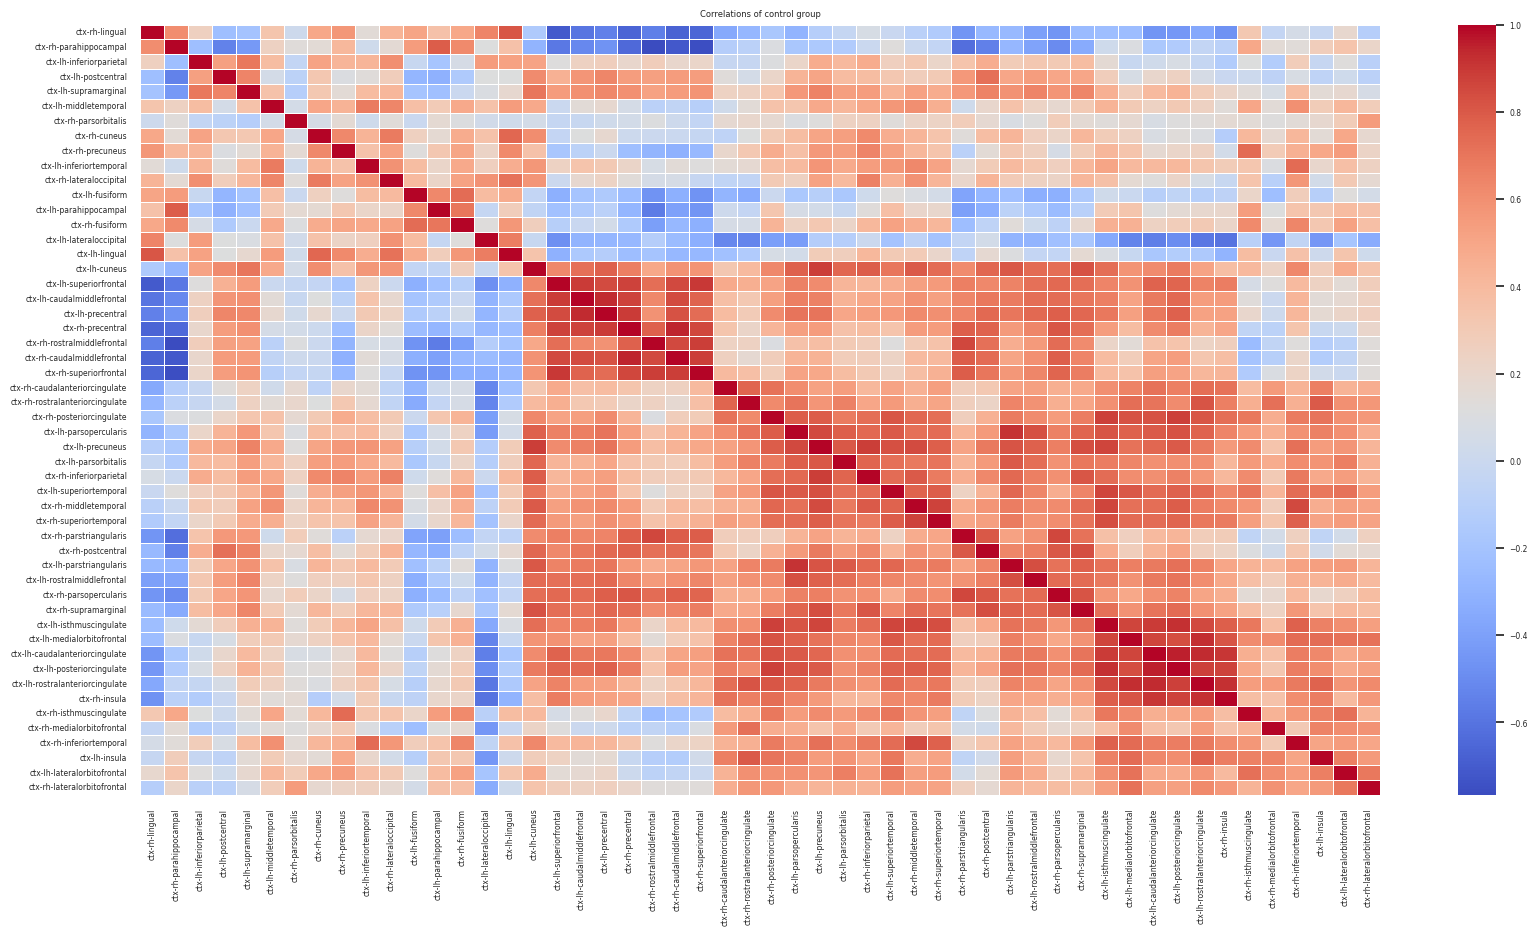

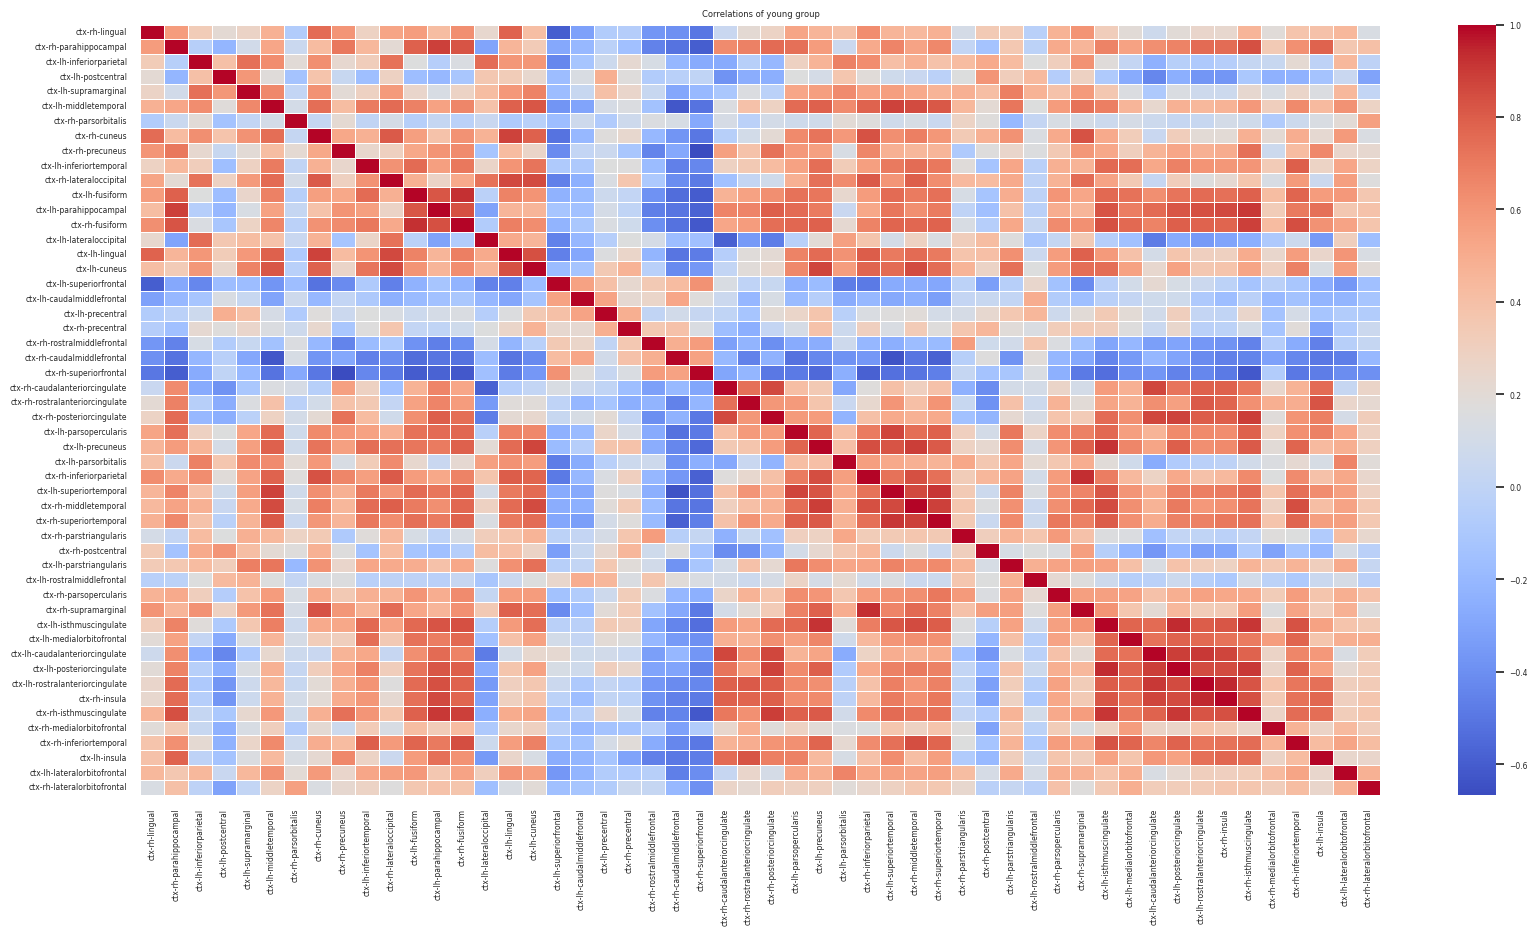

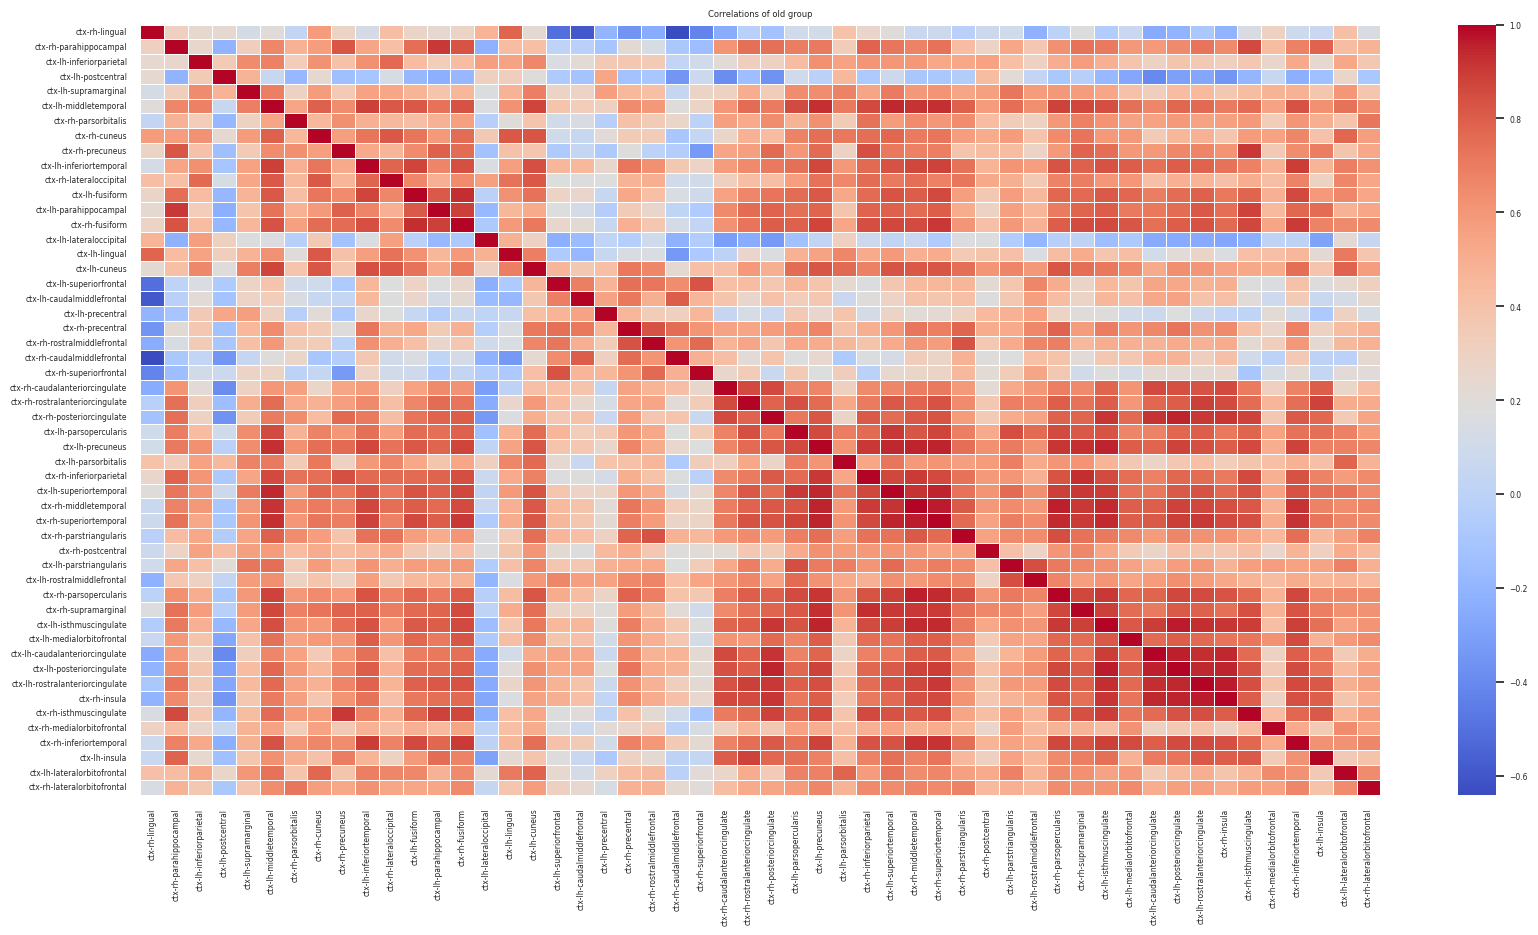

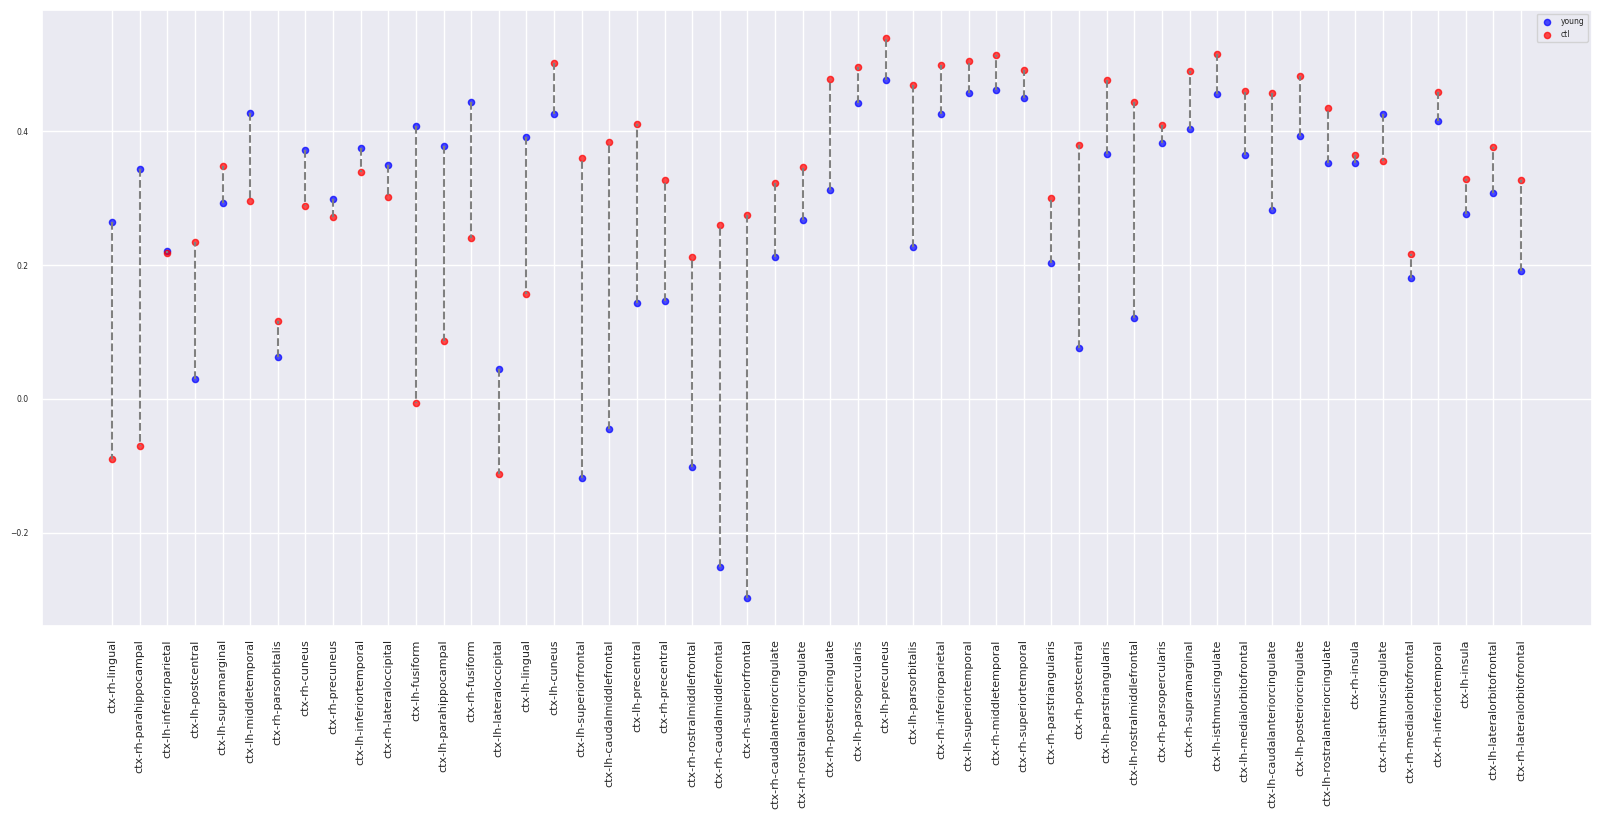

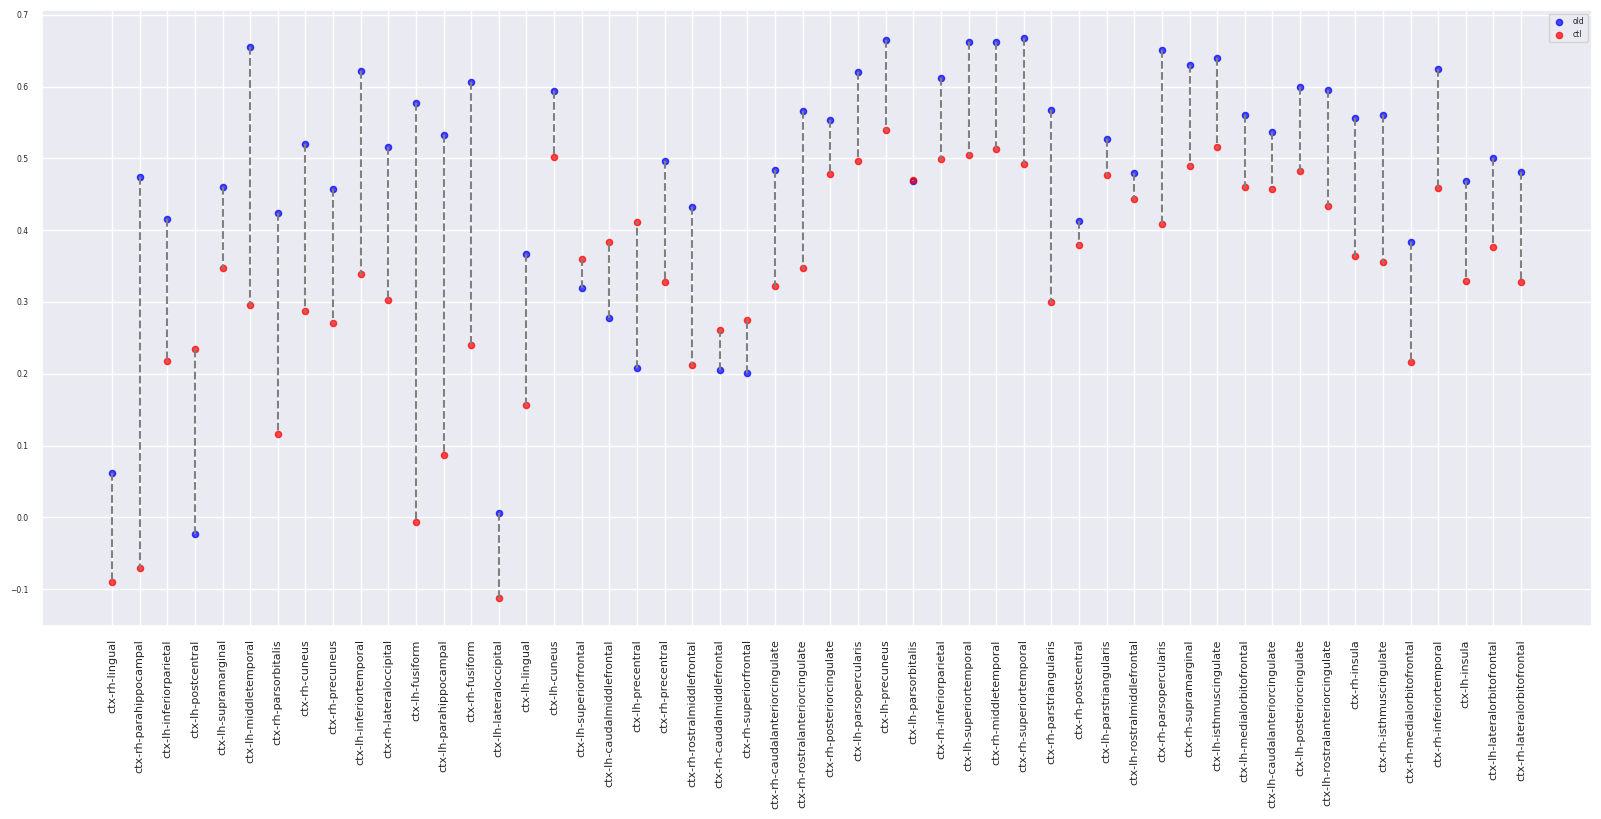

In [10]:
ctl_corr = StatisticsWrapper.roi_correlations(ctl_data_z_score, params_to_work_with, ctl_clustring_data,
                                                          group_title='Correlations of control group')

young_corr = StatisticsWrapper.roi_correlations(young_ctx_data_z_score, params_to_work_with, ctl_clustring_data,
                                                          group_title='Correlations of young group')
old_corr = StatisticsWrapper.roi_correlations(old_ctx_data_z_score, params_to_work_with, ctl_clustring_data,
                                                          group_title='Correlations of old group')

young_corr_means, ctl_corr_means = show_corr_mean(
    young_corr, ctl_corr, ctl_clustring_data, 'young', 'ctl')

old_corr_means, ctl_corr_means = show_corr_mean(
    old_corr, ctl_corr, ctl_clustring_data, 'old', 'ctl')

In [13]:
frobenius_norm = np.linalg.norm(young_distances - ctl_distances, 'fro')
print(f'Frobenius norm: {frobenius_norm}')

Frobenius norm: 10.966008729617519
